<a href="https://colab.research.google.com/github/sriks6711/octopix/blob/main/notebooks/mobileclip-video-search/mobileclip-video-search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Content Search using MobileCLIP and OpenVINO

Semantic visual content search is a machine learning task that uses either a text query or an input image to search a database of images (photo gallery, video) to find images that are semantically similar to the search query.
Historically, building a robust search engine for images was difficult. One could search by features such as file name and image metadata, and use any context around an image (i.e. alt text or surrounding text if an image appears in a passage of text) to provide the richer searching feature. This was before the advent of neural networks that can identify semantically related images to a given user query.

[Contrastive Language-Image Pre-Training (CLIP)](https://arxiv.org/abs/2103.00020) models provide the means through which you can implement a semantic search engine with a few dozen lines of code. The CLIP model has been trained on millions of pairs of text and images, encoding semantics from images and text combined. Using CLIP, you can provide a text query and CLIP will return the images most related to the query.

In this tutorial, we consider how to use MobileCLIP to implement a visual content search engine for finding relevant frames in video.
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Select model](#Select-model)
- [Run model inference](#Run-model-inference)
    - [Prepare image gallery](#Prepare-image-gallery)
    - [Prepare model](#Prepare-model)
    - [Perform search](#Perform-search)
- [Convert Model to OpenVINO Intermediate Representation format](#Convert-Model-to-OpenVINO-Intermediate-Representation-format)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
    - [Select device for image encoder](#Select-device-for-image-encoder)
    - [Select device for text encoder](#Select-device-for-text-encoder)
    - [Perform search](#Perform-search)
- [Interactive Demo](#Interactive-Demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/mobileclip-video-search/mobileclip-video-search.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
from pathlib import Path
import requests

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

if not Path("cmd_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
    )
    open("cmd_helper.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("mobileclip-video-search.ipynb")

In [2]:
from cmd_helper import clone_repo


clone_repo("https://github.com/apple/ml-mobileclip.git")

PosixPath('ml-mobileclip')

In [3]:
%pip install -q "./ml-mobileclip" --no-deps

%pip install -q "clip-benchmark>=1.4.0" "datasets>=2.8.0" "open-clip-torch>=2.20.0" "timm>=0.9.5" "torch>=2.5.0" "torchvision>=0.20.0" --extra-index-url https://download.pytorch.org/whl/cpu

%pip install -q "matplotlib>=3.4" "Pillow"  "altair" "pandas" "tqdm" "opencv-python>=4.9" "gradio>=4.19"
%pip install -q "--no-deps salesforce-lavis==1.0.2" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "contexttimer" "einops>=0.4.1" decord omegaconf sentencepiece timm spacy --extra-index-url https://download.pytorch.org/whl/cpu

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━

In [4]:
%pip install -q  "openvino>=2024.5.0"
%pip install -q "git+https://github.com/huggingface/optimum-intel.git" "transformers>=4.45" "tokenizers>=0.20" --extra-index-url https://download.pytorch.org/whl/cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 MB 17.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 78.5 MB/s eta 0:00:00


## Select model
[back to top ⬆️](#Table-of-contents:)

For starting work, we should select model that will be used in our demonstration.
By default, we will use the MobileCLIP model, but for comparison purposes, you can select different models among:

* **CLIP** - CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on various (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.
CLIP uses a [ViT](https://arxiv.org/abs/2010.11929) like transformer to get visual features and a causal language model to get the text features. The text and visual features are then projected into a latent space with identical dimensions. The dot product between the projected image and text features is then used as a similarity score. You can find more information about this model in the [research paper](https://arxiv.org/abs/2103.00020), [OpenAI blog](https://openai.com/blog/clip/), [model card](https://github.com/openai/CLIP/blob/main/model-card.md) and GitHub [repository](https://github.com/openai/CLIP).
* **SigLIP** -  The SigLIP model was proposed in [Sigmoid Loss for Language Image Pre-Training](https://arxiv.org/abs/2303.15343). SigLIP proposes to replace the loss function used in [CLIP](https://github.com/openai/CLIP) (Contrastive Language–Image Pre-training) by a simple pairwise sigmoid loss. This results in better performance in terms of zero-shot classification accuracy on ImageNet. You can find more information about this model in the [research paper](https://arxiv.org/abs/2303.15343) and [GitHub repository](https://github.com/google-research/big_vision),
* **MobileCLIP** -  MobileCLIP – a new family of efficient image-text models optimized for runtime performance along with a novel and efficient training approach, namely multi-modal reinforced training. The smallest variant MobileCLIP-S0 obtains similar zero-shot performance as OpenAI's CLIP ViT-b16 model while being several times faster and 2.8x smaller. More details about model can be found in [research paper](https://arxiv.org/pdf/2311.17049.pdf) and [GitHub repository](https://github.com/apple/ml-mobileclip).
* **BLIP-2** - BLIP2 was introduced in the paper [BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models](https://arxiv.org/abs/2301.12597) by Li et al. and first released in this [repository](https://github.com/salesforce/LAVIS/tree/main/projects/blip2). It is a generic and efficient pre-training strategy that easily harvests development of pretrained vision models and large language models (LLMs) for vision-language pretraining. BLIP-2 consists of 3 models: a CLIP-like image encoder, a Querying Transformer (Q-Former) and a large language model.

In [5]:
from pathlib import Path

import ipywidgets as widgets


model_dir = Path("checkpoints")


def default_image_probs(image_features, text_features):
    image_probs = (100.0 * text_features @ image_features.T).softmax(dim=-1)
    return image_probs


def blip2_image_probs(image_features, text_features):
    image_probs = image_features[:, 0, :] @ text_features[:, 0, :].t()
    return image_probs


supported_models = {
    "MobileCLIP": {
        "mobileclip_s0": {
            "model_name": "mobileclip_s0",
            "pretrained": model_dir / "mobileclip_s0.pt",
            "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s0.pt",
            "image_size": 256,
            "image_probs": default_image_probs,
        },
        "mobileclip_s1": {
            "model_name": "mobileclip_s1",
            "pretrained": model_dir / "mobileclip_s1.pt",
            "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s1.pt",
            "image_size": 256,
            "image_probs": default_image_probs,
        },
        "mobileclip_s2": {
            "model_name": "mobileclip_s0",
            "pretrained": model_dir / "mobileclip_s2.pt",
            "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s2.pt",
            "image_size": 256,
            "image_probs": default_image_probs,
        },
        "mobileclip_b": {
            "model_name": "mobileclip_b",
            "pretrained": model_dir / "mobileclip_b.pt",
            "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_b.pt",
            "image_size": 224,
            "image_probs": default_image_probs,
        },
        "mobileclip_blt": {
            "model_name": "mobileclip_b",
            "pretrained": model_dir / "mobileclip_blt.pt",
            "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt",
            "image_size": 224,
            "image_probs": default_image_probs,
        },
    },
    "CLIP": {
        "clip-vit-b-32": {
            "model_name": "ViT-B-32",
            "pretrained": "laion2b_s34b_b79k",
            "image_size": 224,
            "image_probs": default_image_probs,
        },
        "clip-vit-b-16": {
            "model_name": "ViT-B-16",
            "pretrained": "openai",
            "image_size": 224,
            "image_probs": default_image_probs,
        },
        "clip-vit-l-14": {
            "model_name": "ViT-L-14",
            "pretrained": "datacomp_xl_s13b_b90k",
            "image_size": 224,
            "image_probs": default_image_probs,
        },
        "clip-vit-h-14": {
            "model_name": "ViT-H-14",
            "pretrained": "laion2b_s32b_b79k",
            "image_size": 224,
            "image_probs": default_image_probs,
        },
    },
    "SigLIP": {
        "siglip-vit-b-16": {
            "model_name": "ViT-B-16-SigLIP",
            "pretrained": "webli",
            "image_size": 224,
            "image_probs": default_image_probs,
        },
        "siglip-vit-l-16": {
            "model_name": "ViT-L-16-SigLIP-256",
            "pretrained": "webli",
            "image_size": 256,
            "image_probs": default_image_probs,
        },
    },
    "Blip2": {
        "blip2_feature_extractor": {
            "model_name": "blip2_feature_extractor",
            "pretrained": "pretrain_vitL",
            "image_size": 224,
            "image_probs": blip2_image_probs,
        },
    },
}


model_type = widgets.Dropdown(options=supported_models.keys(), default="MobileCLIP", description="Model type:")
model_type

Dropdown(description='Model type:', options=('MobileCLIP', 'CLIP', 'SigLIP', 'Blip2'), value='MobileCLIP')

In [6]:
available_models = supported_models[model_type.value]

model_checkpoint = widgets.Dropdown(
    options=available_models.keys(),
    default=list(available_models),
    description="Model:",
)

model_checkpoint

Dropdown(description='Model:', options=('mobileclip_s0', 'mobileclip_s1', 'mobileclip_s2', 'mobileclip_b', 'mo…

In [7]:
from notebook_utils import download_file, device_widget

model_config = available_models[model_checkpoint.value]

## Run model inference
[back to top ⬆️](#Table-of-contents:)

Now, let's see model in action. We will try to find image, where some specific object is represented using embeddings. Embeddings are a numeric representation of data such as text and images. The model learned to encode semantics about the contents of images in embedding format. This ability turns the model into a powerful for solving various tasks including image-text retrieval. To reach our goal we should:

1.  Calculate embeddings for all of the images in our dataset;
2.  Calculate a text embedding for a user query (i.e. "black dog" or "car");
3.  Compare the text embedding to the image embeddings to find related embeddings.

The closer two embeddings are, the more similar the contents they represent are.

### Prepare image gallery
[back to top ⬆️](#Table-of-contents:)

red_panda.png:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

cat.png:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

raccoon.png:   0%|          | 0.00/106k [00:00<?, ?B/s]

dog.png:   0%|          | 0.00/716k [00:00<?, ?B/s]

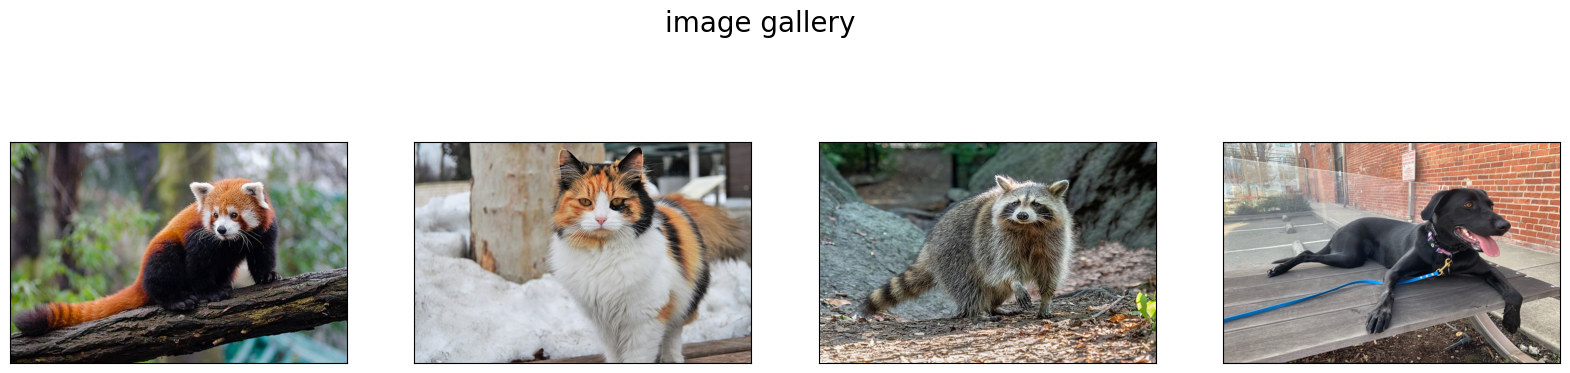

In [8]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def visualize_result(images: List, query: str = "", selected: List[int] = None):
    """
    Utility function for visualization classification results
    params:
      images (List[Image]) - list of images for visualization
      query (str) - title for visualization
      selected (List[int]) - list of selected image indices from images
    returns:
      matplotlib.Figure
    """
    figsize = (20, 5)
    fig, axs = plt.subplots(1, 4, figsize=figsize, sharex="all", sharey="all")
    fig.patch.set_facecolor("white")
    list_axes = list(axs.flat)
    if query:
        fig.suptitle(query, fontsize=20)
    for idx, a in enumerate(list_axes):
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
        a.imshow(images[idx])
        if selected is not None and idx not in selected:
            mask = np.ones_like(np.array(images[idx]))
            a.imshow(mask, "jet", interpolation="none", alpha=0.75)
    return fig


images_urls = [
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/282ce53e-912d-41aa-ab48-2a001c022d74",
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/9bb40168-82b5-4b11-ada6-d8df104c736c",
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/0747b6db-12c3-4252-9a6a-057dcf8f3d4e",
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bricks.png",
]
image_names = ["red_panda.png", "cat.png", "raccoon.png", "dog.png"]
sample_path = Path("data")
sample_path.mkdir(parents=True, exist_ok=True)

images = []
for image_name, image_url in zip(image_names, images_urls):
    image_path = sample_path / image_name
    if not image_path.exists():
        download_file(image_url, filename=image_name, directory=sample_path)
    images.append(Image.open(image_path).convert("RGB").resize((640, 420)))

input_labels = ["cat"]
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

visualize_result(images, "image gallery");

### Prepare model
[back to top ⬆️](#Table-of-contents:)

The code bellow download model weights, create model class instance and preprocessing utilities

In [9]:
import torch


class Blip2Model(torch.nn.Module):
    def __init__(self, ln_vision, visual_encoder, query_tokens, q_former, vision_proj, text_proj, tokenizer):
        super().__init__()
        self.ln_vision = ln_vision
        self.visual_encoder = visual_encoder
        self.query_tokens = query_tokens
        self.q_former = q_former
        self.vision_proj = vision_proj
        self.text_proj = text_proj
        self.tok = tokenizer

    def encode_image(self, image):
        image_embeds_frozen = self.ln_vision(self.visual_encoder(image))
        image_embeds_frozen = image_embeds_frozen.float()
        image_atts = torch.ones(image_embeds_frozen.size()[:-1], dtype=torch.long)
        query_tokens = self.query_tokens.expand(image_embeds_frozen.shape[0], -1, -1)

        query_output = self.q_former.bert(
            query_embeds=query_tokens,
            encoder_hidden_states=image_embeds_frozen,
            encoder_attention_mask=image_atts,
            return_dict=True,
        )
        image_embeds = query_output.last_hidden_state
        image_features = self.vision_proj(image_embeds)

        return image_features

    def encode_text(self, input_ids, attention_mask):
        text_output = self.q_former.bert(
            input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )
        text_embeds = text_output.last_hidden_state
        text_features = self.text_proj(text_embeds)
        return text_features

    def tokenizer(self, text_descriptions):
        input_ids = self.tok(text_descriptions, return_tensors="pt", padding=True).input_ids
        attention_mask = self.tok(text_descriptions, return_tensors="pt", padding=True).attention_mask
        text = {"input_ids": input_ids, "attention_mask": attention_mask}
        return text

In [10]:
import torch
import time
import mobileclip
import open_clip

# instantiate model
model_name = model_config["model_name"]
pretrained = model_config["pretrained"]

if model_type.value == "MobileCLIP":
    model_dir.mkdir(exist_ok=True)
    model_url = model_config["url"]
    download_file(model_url, directory=model_dir)
    model, _, preprocess = mobileclip.create_model_and_transforms(model_name, pretrained=pretrained)
    tokenizer = mobileclip.get_tokenizer(model_name)
elif model_type.value == "Blip2":
    from lavis.models import load_model_and_preprocess

    model, vis_processors, txt_processors = load_model_and_preprocess(name=model_name, model_type=pretrained, is_eval=True)
    model = Blip2Model(model.ln_vision, model.visual_encoder, model.query_tokens, model.Qformer, model.vision_proj, model.text_proj, model.tokenizer)
    preprocess = vis_processors["eval"]
    tokenizer = model.tokenizer
else:
    model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
    tokenizer = open_clip.get_tokenizer(model_name)

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


mobileclip_s0.pt:   0%|          | 0.00/206M [00:00<?, ?B/s]

### Perform search
[back to top ⬆️](#Table-of-contents:)

Image encoding took 1.06 ms
Text encoding took 0.101 ms


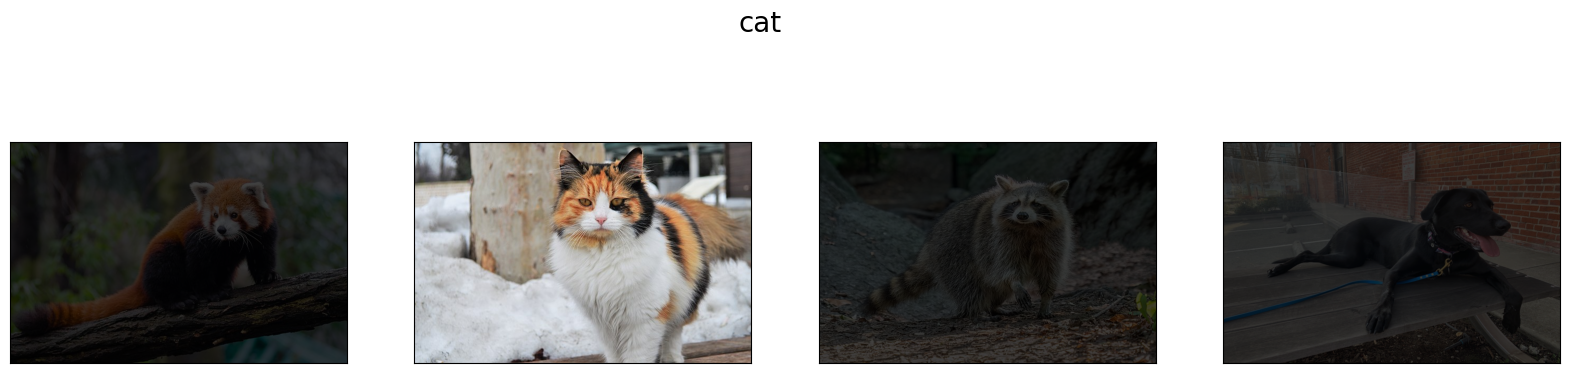

In [11]:
image_tensor = torch.stack([preprocess(image) for image in images])
text = tokenizer(text_descriptions)
image_probs_function = model_config["image_probs"]

with torch.no_grad():
    # calculate image embeddings
    image_encoding_start = time.perf_counter()
    image_features = model.encode_image(image_tensor)
    image_encoding_end = time.perf_counter()
    print(f"Image encoding took {image_encoding_end - image_encoding_start:.3} ms")
    # calculate text embeddings
    text_encoding_start = time.perf_counter()
    text_features = model.encode_text(**text) if model_type.value == "Blip2" else model.encode_text(text)
    text_encoding_end = time.perf_counter()
    print(f"Text encoding took {text_encoding_end - text_encoding_start:.3} ms")

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    image_probs = image_probs_function(image_features, text_features)
    selected_image = [torch.argmax(image_probs).item()]

visualize_result(images, input_labels[0], selected_image);

## Convert Model to OpenVINO Intermediate Representation format
[back to top ⬆️](#Table-of-contents:)

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via Model conversion API.
To convert the PyTorch model to OpenVINO IR format we will use `ov.convert_model` of [model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html). The `ov.convert_model` Python function returns an OpenVINO Model object ready to load on the device and start making predictions.

Our model consist from 2 parts - image encoder and text encoder that can be used separately. Let's convert each part to OpenVINO.

In [12]:
import types
import torch.nn.functional as F


def se_block_forward(self, inputs):
    """Apply forward pass."""
    b, c, h, w = inputs.size()
    x = F.avg_pool2d(inputs, kernel_size=[8, 8])
    x = self.reduce(x)
    x = F.relu(x)
    x = self.expand(x)
    x = torch.sigmoid(x)
    x = x.view(-1, c, 1, 1)
    return inputs * x

In [13]:
import openvino as ov
import gc

ov_models_dir = Path("ov_models")
ov_models_dir.mkdir(exist_ok=True)

image_encoder_path = ov_models_dir / f"{model_checkpoint.value}_im_encoder.xml"

if not image_encoder_path.exists():
    if "mobileclip_s" in model_name:
        model.image_encoder.model.conv_exp.se.forward = types.MethodType(se_block_forward, model.image_encoder.model.conv_exp.se)
    model.forward = model.encode_image
    ov_image_encoder = ov.convert_model(
        model,
        example_input=image_tensor,
        input=[-1, 3, image_tensor.shape[2], image_tensor.shape[3]],
    )
    ov.save_model(ov_image_encoder, image_encoder_path)
    del ov_image_encoder
    gc.collect()

text_encoder_path = ov_models_dir / f"{model_checkpoint.value}_text_encoder.xml"

if not text_encoder_path.exists():
    model.forward = model.encode_text
    if model_type.value == "Blip2":
        ov_text_encoder = ov.convert_model(model, example_input=text)
    else:
        ov_text_encoder = ov.convert_model(model, example_input=text, input=[-1, text.shape[1]])
    ov.save_model(ov_text_encoder, text_encoder_path)
    del ov_text_encoder
    gc.collect()

del model
gc.collect();

/content/ml-mobileclip/mobileclip/modules/common/transformer.py:125: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if seq_len != self.num_embeddings:


## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

### Select device for image encoder
[back to top ⬆️](#Table-of-contents:)

In [14]:
core = ov.Core()

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [15]:
ov_compiled_image_encoder = core.compile_model(image_encoder_path, device.value)
ov_compiled_image_encoder(image_tensor);

### Select device for text encoder
[back to top ⬆️](#Table-of-contents:)

In [16]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [17]:
ov_compiled_text_encoder = core.compile_model(text_encoder_path, device.value)
ov_compiled_text_encoder(text);

### Perform search
[back to top ⬆️](#Table-of-contents:)

Image encoding took 0.252 ms
Text encoding took 0.0345 ms


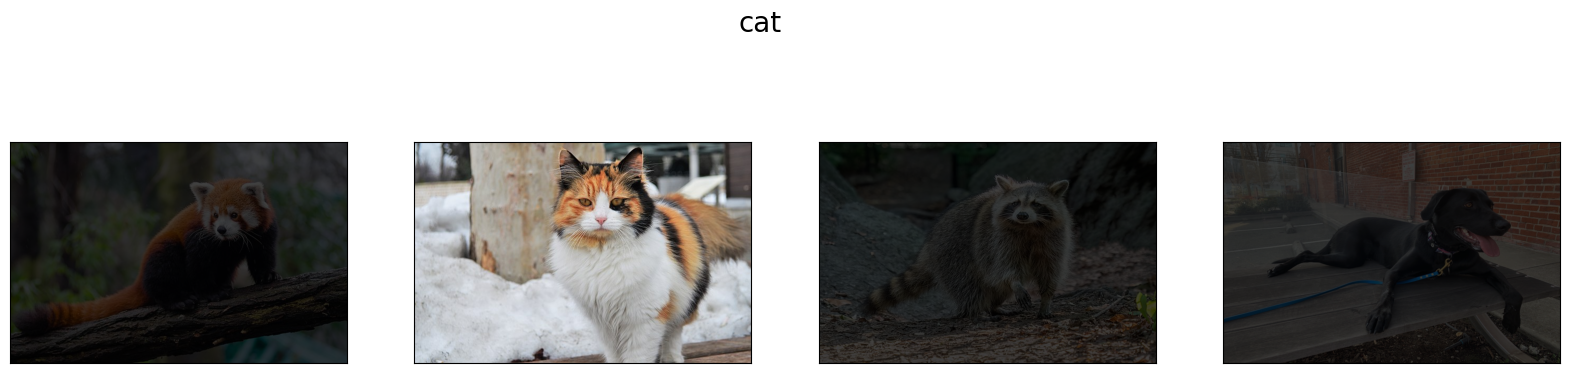

In [18]:
image_encoding_start = time.perf_counter()
image_features = torch.from_numpy(ov_compiled_image_encoder(image_tensor)[0])
image_encoding_end = time.perf_counter()
print(f"Image encoding took {image_encoding_end - image_encoding_start:.3} ms")
text_encoding_start = time.perf_counter()
text_features = torch.from_numpy(ov_compiled_text_encoder(text)[0])
text_encoding_end = time.perf_counter()
print(f"Text encoding took {text_encoding_end - text_encoding_start:.3} ms")
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

image_probs = image_probs_function(image_features, text_features)
selected_image = [torch.argmax(image_probs).item()]

visualize_result(images, input_labels[0], selected_image);

### (optional) Translation model

Since all text embedding models in this notebook natively supports input in English only, we can insert a translation model in this pipeline to support searching in Chinese.

* **opus-mt-zh-en t** - This is a translation model developed by Language Technology Research Group at the University of Helsinki. It supports Chinese as source Language and English as target Language [model card](https://huggingface.co/Helsinki-NLP/opus-mt-zh-en).

In [19]:
from pathlib import Path

cn2en_trans_model_path = "ov_models/cn2en_trans_model"
cn2en_trans_model_id = "Helsinki-NLP/opus-mt-zh-en"

if not Path(cn2en_trans_model_path).exists():
    !optimum-cli export openvino --model {cn2en_trans_model_id} --task text2text-generation-with-past --trust-remote-code {cn2en_trans_model_path}

2025-03-25 12:37:37.936831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742906258.282812    1634 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742906258.374448    1634 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 12:37:39.085539: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
<frozen importlib.util>:262: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in t

In [20]:
from transformers import AutoTokenizer
from optimum.intel import OVModelForSeq2SeqLM

tr_tokenizer = AutoTokenizer.from_pretrained(cn2en_trans_model_path)
tr_model = OVModelForSeq2SeqLM.from_pretrained(cn2en_trans_model_path)

<frozen importlib.util>:262: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


## Interactive Demo
[back to top ⬆️](#Table-of-contents:)

In this part, you can try different supported by tutorial models in searching frames in the video by text query or image. Upload video and provide text query or reference image for search and model will find the most relevant frames according to provided query. You can also try querying in Chinese, and translation model will be triggered automatically for Chinese-to-English translation. Please note, different models can require different optimal threshold for search.

In [21]:
import altair as alt
import cv2
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    Resize,
    ToTensor,
)
from open_clip.transform import image_transform
from typing import Optional


current_device = device.value
current_model = image_encoder_path.name.split("_im_encoder")[0]

available_converted_models = [model_file.name.split("_im_encoder")[0] for model_file in ov_models_dir.glob("*_im_encoder.xml")]
available_devices = list(core.available_devices) + ["AUTO"]

if not (sample_path / "car-detection.mp4").exists():
    download_file(
        "https://storage.openvinotoolkit.org/data/test_data/videos/car-detection.mp4",
        directory=sample_path,
    )
if not Path("coco.mp4").exists():
    download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4",
        directory=sample_path,
        filename="coco.mp4",
    )


def is_english(text):
    for char in text:
        if not char.isascii():
            return False
    return True


def translate(text):
    if tr_tokenizer:
        t = tr_tokenizer(text, return_tensors="pt")
        r = tr_model.generate(**t)
        text = tr_tokenizer.decode(r[0][1:-1])
    return text


def get_preprocess_probs_tokenizer(model_name):
    if "mobileclip" in model_name:
        resolution = supported_models["MobileCLIP"][model_name]["image_size"]
        resize_size = resolution
        centercrop_size = resolution
        aug_list = [
            Resize(
                resize_size,
                interpolation=InterpolationMode.BILINEAR,
            ),
            CenterCrop(centercrop_size),
            ToTensor(),
        ]
        preprocess = Compose(aug_list)
        tokenizer = mobileclip.get_tokenizer(supported_models["MobileCLIP"][model_name]["model_name"])
        image_probs = default_image_probs
    elif "blip2" in model_name:
        from lavis.models import load_model_and_preprocess

        model, vis_processors, txt_processors = load_model_and_preprocess(name=model_name, model_type=pretrained, is_eval=True)
        model = Blip2Model(model.ln_vision, model.visual_encoder, model.query_tokens, model.Qformer, model.vision_proj, model.text_proj, model.tokenizer)
        preprocess = vis_processors["eval"]
        tokenizer = model.tokenizer
        image_probs = blip2_image_probs
    else:
        model_configs = supported_models["SigLIP"] if "siglip" in model_name else supported_models["CLIP"]
        resize_size = model_configs[model_name]["image_size"]
        preprocess = image_transform((resize_size, resize_size), is_train=False, resize_mode="longest")
        tokenizer = open_clip.get_tokenizer(model_configs[model_name]["model_name"])
        image_probs = default_image_probs

    return preprocess, image_probs, tokenizer


def run(
    path: str,
    text_search: str,
    image_search: Optional[Image.Image],
    model_name: str,
    device: str,
    thresh: float,
    stride: int,
    batch_size: int,
):
    assert path, "An input video should be provided"
    assert text_search is not None or image_search is not None, "A text or image query should be provided"
    global current_model
    global current_device
    global preprocess
    global tokenizer
    global ov_compiled_image_encoder
    global ov_compiled_text_encoder
    global image_probs_function

    if current_model != model_name or device != current_device:
        ov_compiled_image_encoder = core.compile_model(ov_models_dir / f"{model_name}_im_encoder.xml", device)
        ov_compiled_text_encoder = core.compile_model(ov_models_dir / f"{model_name}_text_encoder.xml", device)
        preprocess, image_probs_function, tokenizer = get_preprocess_probs_tokenizer(model_name)
        current_model = model_name
        current_device = device
    # Load video
    dataset = LoadVideo(path, transforms=preprocess, vid_stride=stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Get image query features
    if image_search:
        image = preprocess(image_search).unsqueeze(0)
        query_features = torch.from_numpy(ov_compiled_image_encoder(image)[0])
        query_features /= query_features.norm(dim=-1, keepdim=True)
    # Get text query features
    else:
        if not is_english(text_search):
            text_search = translate(text_search)
            print(f"Translated input text: {text_search}")
        # Tokenize search phrase
        text = tokenizer([text_search])
        # Encode text query
        query_features = torch.from_numpy(ov_compiled_text_encoder(text)[0])
        query_features /= query_features.norm(dim=-1, keepdim=True)
    # Encode each frame and compare with query features
    matches = []
    matches_probs = []
    res = pd.DataFrame(columns=["Frame", "Timestamp", "Similarity"])
    for image, orig, frame, timestamp in dataloader:
        with torch.no_grad():
            image_features = torch.from_numpy(ov_compiled_image_encoder(image)[0])

        image_features /= image_features.norm(dim=-1, keepdim=True)
        probs = image_probs_function(image_features, query_features)
        probs = probs.cpu().numpy().squeeze(1) if "blip2" in model_name else probs[0]
        # Save frame similarity values
        df = pd.DataFrame(
            {
                "Frame": frame.tolist(),
                "Timestamp": torch.round(timestamp / 1000, decimals=2).tolist(),
                "Similarity": probs.tolist(),
            }
        )
        res = pd.concat([res, df])

        # Check if frame is over threshold
        for i, p in enumerate(probs):
            if p > thresh:
                matches.append(to_pil_image(orig[i]))
                matches_probs.append(p)

        print(f"Frames: {frame.tolist()} - Probs: {probs}")

    # Create plot of similarity values
    lines = (
        alt.Chart(res)
        .mark_line(color="firebrick")
        .encode(
            alt.X("Timestamp", title="Timestamp (seconds)"),
            alt.Y("Similarity", scale=alt.Scale(zero=False)),
        )
    ).properties(width=600)
    rule = alt.Chart().mark_rule(strokeDash=[6, 3], size=2).encode(y=alt.datum(thresh))

    selected_frames = np.argsort(-1 * np.array(matches_probs))[:20]
    matched_sorted_frames = [matches[idx] for idx in selected_frames]

    return (
        lines + rule,
        matched_sorted_frames,
    )  # Only return up to 20 images to not crash the UI


class LoadVideo(Dataset):
    def __init__(self, path, transforms, vid_stride=1):
        self.transforms = transforms
        self.vid_stride = vid_stride
        self.cur_frame = 0
        self.cap = cv2.VideoCapture(path)
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) / self.vid_stride)

    def __getitem__(self, _):
        # Read video
        # Skip over frames
        for _ in range(self.vid_stride):
            self.cap.grab()
            self.cur_frame += 1

        # Read frame
        _, img = self.cap.retrieve()
        timestamp = self.cap.get(cv2.CAP_PROP_POS_MSEC)

        # Convert to PIL
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(np.uint8(img))

        # Apply transforms
        img_t = self.transforms(img)

        return img_t, to_tensor(img), self.cur_frame, timestamp

    def __len__(self):
        return self.total_frames

car-detection.mp4:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

coco.mp4:   0%|          | 0.00/877k [00:00<?, ?B/s]

In [22]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/mobileclip-video-search/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo, Option

demo = make_demo(
    run=run,
    model_option=Option(choices=available_converted_models, value=model_checkpoint.value),
    device_option=Option(choices=available_devices, value=device.value),
)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

/usr/local/lib/python3.11/dist-packages/websockets/legacy/__init__.py:6: DeprecationWarning: websockets.legacy is deprecated; see https://websockets.readthedocs.io/en/stable/howto/upgrade.html for upgrade instructions
  warnings.warn(  # deprecated in 14.0 - 2024-11-09
/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/uvicorn/protocols/websockets/websockets_impl.py:17: DeprecationWarning: websockets.server.WebSocketServerProtocol is deprecated
  from websockets.server import WebSocketServerProtocol


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1a0cf4a2f449d981b1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Frames: [4, 8, 12, 16] - Probs: tensor([0.1135, 0.1847, 0.3201, 0.3816])
Frames: [20, 24, 28, 32] - Probs: tensor([0.1239, 0.2657, 0.1334, 0.4770])
Frames: [36, 40, 44, 48] - Probs: tensor([0.2951, 0.1934, 0.1046, 0.4070])
Frames: [52, 56, 60, 64] - Probs: tensor([0.4659, 0.1868, 0.1548, 0.1926])
Frames: [68, 72, 76, 80] - Probs: tensor([0.1606, 0.2353, 0.1959, 0.4082])
Frames: [84, 88, 92, 96] - Probs: tensor([0.2559, 0.2874, 0.3450, 0.1118])
Frames: [100, 104, 108, 112] - Probs: tensor([0.4048, 0.2658, 0.2040, 0.1254])
Frames: [116, 120, 124, 128] - Probs: tensor([0.1337, 0.1778, 0.1098, 0.5788])
Frames: [132, 136, 140, 144] - Probs: tensor([0.1626, 0.1752, 0.3117, 0.3506])
Frames: [148, 152, 156, 160] - Probs: tensor([0.2030, 0.0560, 0.0883, 0.6527])
Frames: [164, 168, 172, 176] - Probs: tensor([0.1968, 0.3402, 0.3346, 0.1284])
Frames: [180, 184, 188, 192] - Probs: tensor([0.2467, 0.2954, 0.3274, 0.1305])
Frames: [196, 200, 204, 208] - Probs: tensor([0.2147, 0.3921, 0.2669, 0.1263])